In [1]:
from __future__ import print_function
from numpy.random import seed
seed(1035)
from tensorflow import set_random_seed
set_random_seed(9253)
#get_ipython().run_line_magic('matplotlib', 'inline')

import numpy as np
import h5py
import keras
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

from keras import backend as K
from keras import losses, regularizers
from keras.models import Sequential, Model
from keras.layers import Input, RepeatVector, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate
from keras.engine.topology import Layer
from keras.layers.wrappers import TimeDistributed
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from tensorflow.contrib import distributions

from scipy.optimize import curve_fit

Using TensorFlow backend.


In [2]:
N_slice = 10
T = 500

G = 6.67259e-8 #Gravitational constant in cm^3/g/s^2
c = 2.99792458e10 #Speed of light in vacuum in cm/s
Msun = 1.99e33 #solar mass in grams

input_shape = (128, 128, 1)
target_shape = (5)
epochs = 1000
batch_size = 32
callback = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=0, cooldown=2),
           EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=True)]#,
           #ModelCheckpoint(filepath='Bay_checkpoint-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=5)]
reg = regularizers.l2(0.0)
dropout_rate = 0.01


In [3]:
def scaled_sigmoid(x):
   return (1.4*K.sigmoid(x))-0.2

def bay_loss(y_true, y_pred):
   
    mean = y_pred[:,:target_shape]
    sig = y_pred[:,target_shape:]
    return (K.square(y_true - mean)/(2*sig*sig) + 0.5*K.log(sig*sig))/batch_size

In [4]:
randInt = np.random.randint(100, size=N_slice)

N_T = [randInt[i] for i in range(len(randInt))]
print(N_T)
N_T = set(N_T)
N_T = list(N_T)
print(N_T)
print(len(N_T))
T_val = np.zeros(len(N_T))
for i in range(len(N_T)):
    T_val[i] = 1000-(N_T[i]*1)
print(T_val)
print(np.sort(T_val))
print(len(T_val))

[9, 15, 64, 28, 89, 93, 29, 8, 73, 0]
[64, 0, 8, 9, 73, 15, 29, 89, 28, 93]
10
[ 936. 1000.  992.  991.  927.  985.  971.  911.  972.  907.]
[ 907.  911.  927.  936.  971.  972.  985.  991.  992. 1000.]
10


In [5]:
def data_splitting(data):
    split = np.zeros([100000, len(T_val)])
    split_temp = np.zeros([100000, len(T_val)])
    for i in range(len(T_val)):
        split[:,i] = K.get_value(K.equal(data['y_new'][:,3], T_val[i]))

    split = K.get_value(K.sum(split, axis=1))
    x_val = data['x_new'][(np.where((split) == 1))[0],:]
    y_val = data['y_new'][(np.where((split) == 1))[0],:]
    x_train = data['x_new'][(np.where((split) == 0))[0],:]
    y_train = data['y_new'][(np.where((split) == 0))[0],:]




    Nval = x_val.shape[0]
    return x_val, y_val, x_train, y_train, Nval

In [6]:
def store_variables(pred, y_val):
    i_pred = pred[:,0]
    Mdot_pred = pred[:,1]
    R_pred = pred[:,2]
    M_pred = pred[:,3]
    RA_pred = pred[:,4]

    i_sig = pred[:,5]
    Mdot_sig = pred[:,6]
    R_sig = pred[:,7]
    M_sig = pred[:,8]
    RA_sig = pred[:,9]

    i_true = y_val[:,0]
    Mdot_true = y_val[:,1]
    R_true = y_val[:,2]
    M_true = y_val[:,6]
    RA_true = y_val[:,7]
    
    return i_pred, Mdot_pred, R_pred, M_pred, i_sig, Mdot_sig, R_sig, M_sig, i_true, Mdot_true, R_true, M_true, RA_pred, RA_sig, RA_true


In [7]:
def montecarlo_prediction(model, x_val, T):
    K.set_learning_phase(1)
    predictions = np.array([model.predict(x_val) for _ in range(T)])
    K.set_learning_phase(0)
    return predictions

In [8]:
def error(epis, x_val):
    means = epis[:,:,:target_shape]
    variations = epis[:,:,target_shape:]
    
    i_predi = np.mean(means[:,:,0], axis=0)
    i_err = np.sqrt(np.var(means[:,:,0], axis=0)+np.mean(variations[:,:,0]**2, axis=0))
    Mdot_predi = np.mean(means[:,:,1], axis=0)
    Mdot_err = np.sqrt(np.var(means[:,:,1], axis=0)+np.mean(variations[:,:,1]**2, axis=0))
    R_predi = np.mean(means[:,:,2], axis=0)
    R_err = np.sqrt(np.var(means[:,:,2], axis=0)+np.mean(variations[:,:,2]**2, axis=0))
    M_predi = np.mean(means[:,:,3], axis=0)
    M_err = np.sqrt(np.var(means[:,:,3], axis=0)+np.mean(variations[:,:,3]**2, axis=0))
    RA_predi = np.mean(means[:,:,4], axis=0)
    RA_err = np.sqrt(np.var(means[:,:,4], axis=0)+np.mean(variations[:,:,4]**2, axis=0))

    
    return i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_predi, RA_err

def error_old(epis, x_val):
    means = epis[:,:,:target_shape]
    variations = epis[:,:,target_shape:]
    new_means_i = np.random.normal(means[:,:,0], variations[:,:,0], (T,len(x_val)))
    new_means_Mdot = np.random.normal(means[:,:,1], variations[:,:,1], (T,len(x_val)))
    new_means_R = np.random.normal(means[:,:,2], variations[:,:,2], (T,len(x_val)))
    new_means_M = np.random.normal(means[:,:,3], variations[:,:,3], (T,len(x_val)))
    new_means_RA = np.random.normal(means[:,:,4], variations[:,:,4], (T,len(x_val)))
    
    i_predi = np.mean(new_means_i, axis=0)
    Mdot_predi = np.mean(new_means_Mdot, axis=0)
    R_predi = np.mean(new_means_R, axis=0)
    M_predi = np.mean(new_means_M, axis=0)
    RA_predi = np.mean(new_means_RA, axis=0)

    i_err = np.sqrt(np.var(new_means_i, axis=0))
    Mdot_err = np.sqrt(np.var(new_means_Mdot, axis=0))
    R_err = np.sqrt(np.var(new_means_R, axis=0))
    M_err = np.sqrt(np.var(new_means_M, axis=0))
    RA_err = np.sqrt(np.var(new_means_RA, axis=0))
    
    return i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_predi, RA_err

In [9]:
def sigma(Nsig, i_true, Mdot_true, R_true, M_true, i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_true, RA_predi, RA_err):
    print(Nsig, 'sigma')
    
    i_abs=[]
    for j in range(len(i_predi)):
        if i_true[j]-i_predi[j] < 0:
            i_abs.append(i_predi[j]-Nsig*np.abs(i_err[j]))
        else:
            i_abs.append(i_predi[j]+Nsig*np.abs(i_err[j]))

        
    signi=((i_true-np.array(i_abs))*(i_true-i_predi))
#print how many elements are inside of 1 sigma error bounds. 68.3% corresponds to 1046 elements
    print('Inclination: ', len(np.where(signi<0)[0])/Nval)

    Mdot_abs=[]
    for j in range(len(Mdot_pred)):
        if (Mdot_true[j]-Mdot_predi[j]) < 0:
            Mdot_abs.append(Mdot_predi[j]-Nsig*np.abs(Mdot_err[j]))
        else:
            Mdot_abs.append(Mdot_predi[j]+Nsig*np.abs(Mdot_err[j]))
#print(len(np.where(np.array(M_abs)<0)[0]))
    signMdot=((Mdot_true-np.array(Mdot_abs))*(Mdot_true-Mdot_predi))
    print('Mass accretion rate: ', len(np.where(signMdot<0)[0])/Nval)

    R_abs=[]
    for j in range(len(R_pred)):
        if (R_true[j]-R_predi[j]) < 0:
            R_abs.append(R_predi[j]-Nsig*np.abs(R_err[j]))
        else:
            R_abs.append(R_predi[j]+Nsig*np.abs(R_err[j]))
#print(len(np.where(np.array(R_abs)<0)[0]))
    signR=((R_true-np.array(R_abs))*(R_true-R_predi))
    print('Rhigh:', len(np.where(signR<0)[0])/Nval)

    M_abs=[]
    for j in range(len(M_predi)):
        if (M_true[j]-M_predi[j]) < 0:
            M_abs.append(M_predi[j]-Nsig*np.abs(M_err[j]))
        else:
            M_abs.append(M_predi[j]+Nsig*np.abs(M_err[j]))
#print(len(np.where(np.array(M_abs)<0)[0]))
    signM=((M_true-np.array(M_abs))*(M_true-M_predi))
    print('Mass: ', len(np.where(signM<0)[0])/Nval)
    
    RA_abs=[]
    for j in range(len(RA_predi)):
        if (RA_true[j]-RA_predi[j]) < 0:
            RA_abs.append(RA_predi[j]-Nsig*np.abs(RA_err[j]))
        else:
            RA_abs.append(RA_predi[j]+Nsig*np.abs(RA_err[j]))
#print(len(np.where(np.array(M_abs)<0)[0]))
    signRA=((RA_true-np.array(RA_abs))*(RA_true-RA_predi))
    print('RA: ', len(np.where(signRA<0)[0])/Nval)


    return signi, signMdot, signR, signM, signRA

In [10]:
def sigma_locations(i_true, Mdot_true, R_true, M_true, i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_true, RA_predi, RA_err):
    signi, signMdot, signR, signM, signRA = sigma(1, i_true, Mdot_true, R_true, M_true, i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_true, RA_predi, RA_err)
    loc_i_1 = np.where(signi<0)[0]
    loc_Mdot_1 = np.where(signMdot<0)[0]
    loc_R_1 = np.where(signR<0)[0]
    loc_M_1 = np.where(signM<0)[0]
    loc_RA_1 = np.where(signRA<0)[0]

    
    signi, signMdot, signR, signM, signRA = sigma(2, i_true, Mdot_true, R_true, M_true, i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_true, RA_predi, RA_err)
    loc_i_2 = np.where(signi<0)[0]
    loc_Mdot_2 = np.where(signMdot<0)[0]
    loc_R_2 = np.where(signR<0)[0]
    loc_M_2 = np.where(signM<0)[0]
    loc_RA_2 = np.where(signRA<0)[0]

    
    signi, signMdot, signR, signM, signRA = sigma(3, i_true, Mdot_true, R_true, M_true, i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_true, RA_predi, RA_err)
    loc_i_3 = np.where(signi<0)[0]
    loc_Mdot_3 = np.where(signMdot<0)[0]
    loc_R_3 = np.where(signR<0)[0]
    loc_M_3 = np.where(signM<0)[0]
    loc_RA_3 = np.where(signRA<0)[0]

    
    loc_i_3 = list((set(loc_i_3)-set(loc_i_2)))
    loc_i_2 = list((set(loc_i_2)-set(loc_i_1)))
    loc_Mdot_3 = list((set(loc_Mdot_3)-set(loc_Mdot_2)))
    loc_Mdot_2 = list((set(loc_Mdot_2)-set(loc_Mdot_1)))
    loc_R_3 = list((set(loc_R_3)-set(loc_R_2)))
    loc_R_2 = list((set(loc_R_2)-set(loc_R_1)))
    loc_M_3 = list((set(loc_M_3)-set(loc_M_2)))
    loc_M_2 = list((set(loc_M_2)-set(loc_M_1)))
    loc_RA_3 = list((set(loc_RA_3)-set(loc_RA_2)))
    loc_RA_2 = list((set(loc_RA_2)-set(loc_RA_1)))

    
    return loc_i_3, loc_i_2, loc_i_1, loc_Mdot_3, loc_Mdot_2, loc_Mdot_1, loc_R_3, loc_R_2, loc_R_1, loc_M_3, loc_M_2, loc_M_1, loc_RA_3, loc_RA_2, loc_RA_1

In [11]:
def pred_per_sig(i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, i_true, Mdot_true, R_true, M_true, loc_i_3, loc_i_2, loc_i_1, loc_Mdot_3, loc_Mdot_2, loc_Mdot_1, loc_R_3, loc_R_2, loc_R_1, loc_M_3, loc_M_2, loc_M_1, sin_predi, sin_err, sin_true, loc_sin_3, loc_sin_2, loc_sin_1):
    pred_i_three =  i_predi[loc_i_3]
    pred_i_two = i_predi[loc_i_2]
    pred_i_one = i_predi[loc_i_1]
    true_i_three =  i_true[loc_i_3]
    true_i_two = i_true[loc_i_2]
    true_i_one = i_true[loc_i_1]
    err_i_three =  i_err[loc_i_3]
    err_i_two = i_err[loc_i_2]
    err_i_one = i_err[loc_i_1]

    pred_Mdot_three =  Mdot_predi[loc_Mdot_3]
    pred_Mdot_two = Mdot_predi[loc_Mdot_2]
    pred_Mdot_one = Mdot_predi[loc_Mdot_1]
    true_Mdot_three =  Mdot_true[loc_Mdot_3]
    true_Mdot_two = Mdot_true[loc_Mdot_2]
    true_Mdot_one = Mdot_true[loc_Mdot_1]
    err_Mdot_three =  Mdot_err[loc_Mdot_3]
    err_Mdot_two = Mdot_err[loc_Mdot_2]
    err_Mdot_one = Mdot_err[loc_Mdot_1]

    pred_R_three =  R_predi[loc_R_3]
    pred_R_two = R_predi[loc_R_2]
    pred_R_one = R_predi[loc_R_1]
    true_R_three =  R_true[loc_R_3]
    true_R_two = R_true[loc_R_2]
    true_R_one = R_true[loc_R_1]
    err_R_three =  R_err[loc_R_3]
    err_R_two = R_err[loc_R_2]
    err_R_one = R_err[loc_R_1]

    pred_M_three =  M_predi[loc_M_3]
    pred_M_two = M_predi[loc_M_2]
    pred_M_one = M_predi[loc_M_1]
    true_M_three =  M_true[loc_M_3]
    true_M_two = M_true[loc_M_2]
    true_M_one = M_true[loc_M_1]
    err_M_three =  M_err[loc_M_3]
    err_M_two = M_err[loc_M_2]
    err_M_one = M_err[loc_M_1]
    
    pred_sin_three =  sin_predi[loc_sin_3]
    pred_sin_two = sin_predi[loc_sin_2]
    pred_sin_one = sin_predi[loc_sin_1]
    true_sin_three =  sin_true[loc_sin_3]
    true_sin_two = sin_true[loc_sin_2]
    true_sin_one = sin_true[loc_sin_1]
    err_sin_three =  sin_err[loc_sin_3]
    err_sin_two = sin_err[loc_sin_2]
    err_sin_one = sin_err[loc_sin_1]

    
    return pred_i_three, pred_i_two, pred_i_one, true_i_three, true_i_two, true_i_one, err_i_three, err_i_two, err_i_one, pred_Mdot_three, pred_Mdot_two, pred_Mdot_one, true_Mdot_three, true_Mdot_two, true_Mdot_one, err_Mdot_three, err_Mdot_two, err_Mdot_one, pred_R_three, pred_R_two, pred_R_one, true_R_three, true_R_two, true_R_one, err_R_three, err_R_two, err_R_one, pred_M_three, pred_M_two, pred_M_one, true_M_three, true_M_two, true_M_one, err_M_three, err_M_two, err_M_one, pred_sin_three, pred_sin_two, pred_sin_one, true_sin_three, true_sin_two, true_sin_one, err_sin_three, err_sin_two, err_sin_one 

# 230 GHz 20 micro-arcsec blur

In [53]:
data = h5py.File('dataV6_230_20.h5')

In [54]:
x_val, y_val, x_train, y_train, Nval = data_splitting(data)

In [55]:
inputs = Input(input_shape)

x=Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 kernel_regularizer=reg,
                 input_shape=input_shape) (inputs)
x=MaxPooling2D(pool_size=(2, 2), padding='same') (x)
x=Dropout(dropout_rate) (x)
x=Conv2D(32, (3, 3), activation='relu', kernel_regularizer=reg) (x)
x=MaxPooling2D(pool_size=(2, 2), padding='same') (x)
x=Dropout(dropout_rate)(x)
x=Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg)(x)
x=MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#x=Dropout(dropout_rate)(x)
#x=Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg)(x)
#x=MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#x=Dropout(dropout_rate)(x)
#x=Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg)(x)
#x=MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x=Flatten()(x)
#x=Dropout(dropout_rate)(x)
#x=Dense(8, activation='relu', kernel_regularizer=reg)(x)
#means=Dense(3, activation=scaled_sigmoid)(x)
#sigma=Dense(3,activation=K.exp)(x)

#net = Flatten()(net.output)
arms = []
for i in range(target_shape):
    arm = Dense(64, activation='relu', kernel_regularizer=reg) (x)
    arm = Dropout(dropout_rate)(arm)
    arm = Dense(32, activation='relu', kernel_regularizer=reg) (arm)
    arm = Dropout(dropout_rate)(arm)
    arm = Dense(16, activation='relu', kernel_regularizer=reg) (arm)
    arm_mean = Dense(1, activation='linear', kernel_regularizer=reg) (arm)
    arm_var = Dense(1, activation='tanh', kernel_regularizer=reg) (arm)
    arm_var = Dense(1, activation='linear', kernel_regularizer=reg) (arm_var)
    arm_var = Dense(1, activation=K.exp, kernel_regularizer=reg) (arm_var)
    arms.append([arm_mean, arm_var])

arms = np.array(arms)
outputs = Concatenate() ([*arms[:, 0], *arms[:, 1]])



#output=Concatenate()([means,sigma])

model = Model(inputs=inputs, outputs=outputs)




In [56]:
model.compile(loss=bay_loss,
              optimizer=keras.optimizers.adam(lr = 1e-3))
#             optimizer=keras.optimizers.sgd(lr = 5e-3))

In [57]:
history = model.fit(x_train, y_train[:,[0,1,2,6, 7]],
          batch_size=batch_size,
          shuffle="batch",
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val[:,[0,1,2,6, 7]]),
          callbacks = callback)

Train on 90000 samples, validate on 10000 samples
Epoch 1/1000
90000/90000 [==============================] - 53s 587us/step - loss: -0.0319 - val_loss: -0.0343
Epoch 2/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0360 - val_loss: -0.0363
Epoch 3/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0370 - val_loss: -0.0367
Epoch 4/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0379 - val_loss: -0.0379
Epoch 5/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0386 - val_loss: -0.0389
Epoch 6/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0390 - val_loss: -0.0388
Epoch 7/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0395 - val_loss: -0.0397
Epoch 8/1000
90000/90000 [==============================] - 50s 555us/step - loss: -0.0398 - val_loss: -0.0401
Epoch 9/1000
90000/90000 [==============================] - 50

In [58]:
score = model.evaluate(x_val, y_val[:,[0,1,2,6, 7]], verbose=0)
#model.save('/home/jgucht/ML/V6/models/20_blur.h5')
print('Test loss:', score)


pred = model.predict(x_val)

Test loss: -0.043919719409942624


In [59]:
#model = load_model('/home/jgucht/ML/V5/models/20_blur.h5', custom_objects = {"exp": K.exp,"bay_loss":bay_loss})
#score = model.evaluate(x_val, y_val[:,[0,1,2,6, 7]], verbose=0)

#print('Test loss:', score)


#pred = model.predict(x_val)

In [60]:
i_pred, Mdot_pred, R_pred, M_pred, i_sig, Mdot_sig, R_sig, M_sig, i_true, Mdot_true, R_true, M_true, RA_pred, RA_sig, RA_true = store_variables(pred, y_val)

In [61]:
epis = montecarlo_prediction(model,x_val, T)

In [62]:
i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_predi, RA_err = error(epis, x_val)

In [63]:
loc_i_3, loc_i_2, loc_i_1, loc_Mdot_3, loc_Mdot_2, loc_Mdot_1, loc_R_3, loc_R_2, loc_R_1, loc_M_3, loc_M_2, loc_M_1, loc_RA_3, loc_RA_2, loc_RA_1 = sigma_locations(i_true, Mdot_true, R_true, M_true, i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, RA_true, RA_predi, RA_err)

1 sigma
Inclination:  0.5837
Mass accretion rate:  0.781
Rhigh: 0.6015
Mass:  0.6882
RA:  0.7283
2 sigma
Inclination:  0.9974
Mass accretion rate:  0.9542
Rhigh: 0.9843
Mass:  0.9451
RA:  0.9425
3 sigma
Inclination:  1.0
Mass accretion rate:  0.9799
Rhigh: 0.9982
Mass:  0.9901
RA:  0.9854


In [64]:
pred_i_three_20mas_blur, pred_i_two_20mas_blur, pred_i_one_20mas_blur,\
true_i_three_20mas_blur, true_i_two_20mas_blur, true_i_one_20mas_blur,\
err_i_three_20mas_blur, err_i_two_20mas_blur, err_i_one_20mas_blur,\
pred_Mdot_three_20mas_blur, pred_Mdot_two_20mas_blur, pred_Mdot_one_20mas_blur,\
true_Mdot_three_20mas_blur, true_Mdot_two_20mas_blur, true_Mdot_one_20mas_blur,\
err_Mdot_three_20mas_blur, err_Mdot_two_20mas_blur, err_Mdot_one_20mas_blur,\
pred_R_three_20mas_blur, pred_R_two_20mas_blur, pred_R_one_20mas_blur,\
true_R_three_20mas_blur, true_R_two_20mas_blur, true_R_one_20mas_blur,\
err_R_three_20mas_blur, err_R_two_20mas_blur, err_R_one_20mas_blur,\
pred_M_three_20mas_blur, pred_M_two_20mas_blur, pred_M_one_20mas_blur,\
true_M_three_20mas_blur, true_M_two_20mas_blur, true_M_one_20mas_blur,\
err_M_three_20mas_blur, err_M_two_20mas_blur, err_M_one_20mas_blur,\
pred_RA_three_20mas_blur, pred_RA_two_20mas_blur, pred_RA_one_20mas_blur, true_RA_three_20mas_blur,\
true_RA_two_20mas_blur, true_RA_one_20mas_blur, err_RA_three_20mas_blur, err_RA_two_20mas_blur, err_RA_one_20mas_blur = \
pred_per_sig(i_predi, Mdot_predi, R_predi, M_predi, i_err, Mdot_err, R_err, M_err, i_true, Mdot_true, R_true, M_true, \
loc_i_3, loc_i_2, loc_i_1, loc_Mdot_3, loc_Mdot_2, loc_Mdot_1, loc_R_3, loc_R_2, loc_R_1, loc_M_3, loc_M_2, loc_M_1, \
RA_predi, RA_err, RA_true, loc_RA_3, loc_RA_2, loc_RA_1)

In [65]:
i_true_20 = i_true 
Mdot_true_20 = Mdot_true 
R_true_20 = R_true 
M_true_20 = M_true
RA_true_20 = RA_true

i_pred_20 = i_predi
Mdot_pred_20 = Mdot_predi 
R_pred_20 = R_predi 
M_pred_20 = M_predi
RA_pred_20 = RA_predi

i_err_20 = i_err
Mdot_err_20 = Mdot_err
R_err_20 = R_err 
M_err_20 = M_err
RA_err_20 = RA_err

# Plotting

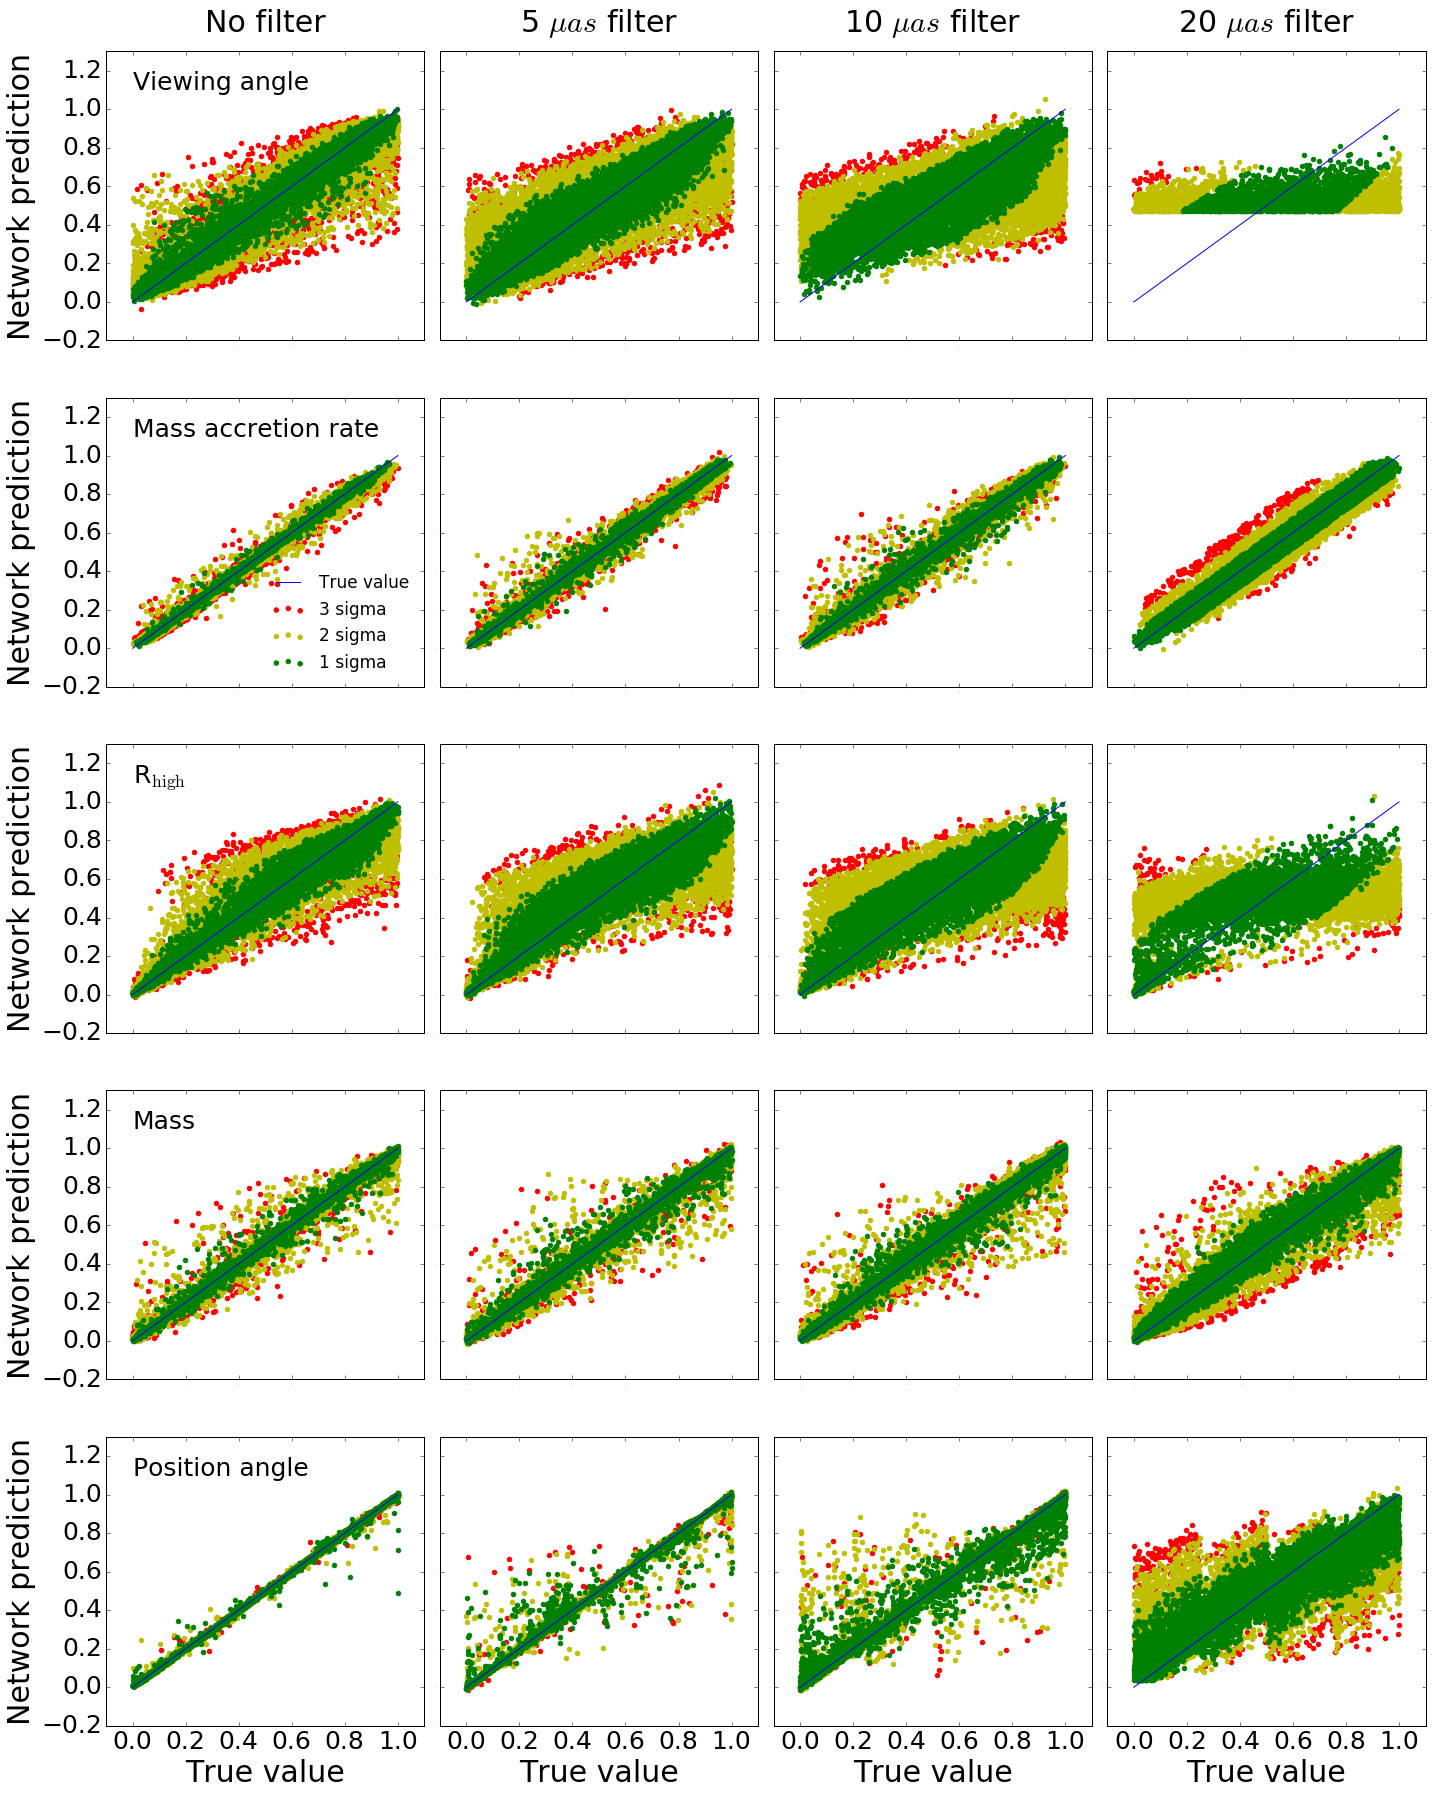

In [79]:
plt.clf()
cmaps = ['r', 'y', 'g']
crange = [1, 2, 3]
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

fig = plt.figure(figsize=(20, 25))
gs = GridSpec(5, 4)

#fig.suptitle("690 GHz", y=1.05, size=20)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[4, 0])
ax6 = fig.add_subplot(gs[0, 1])
ax7 = fig.add_subplot(gs[1, 1])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[3, 1])
ax10 = fig.add_subplot(gs[4, 1])
ax11 = fig.add_subplot(gs[0, 2])
ax12 = fig.add_subplot(gs[1, 2])
ax13 = fig.add_subplot(gs[2, 2])
ax14 = fig.add_subplot(gs[3, 2])
ax15 = fig.add_subplot(gs[4, 2])
ax16 = fig.add_subplot(gs[0, 3])
ax17 = fig.add_subplot(gs[1, 3])
ax18 = fig.add_subplot(gs[2, 3])
ax19 = fig.add_subplot(gs[3, 3])
ax20 = fig.add_subplot(gs[4, 3])


##

##

ax16.scatter(true_i_three_20mas_blur, pred_i_three_20mas_blur, color=cmaps[0], alpha = 1, label='3 sigma')
ax16.scatter(true_i_two_20mas_blur, pred_i_two_20mas_blur, color=cmaps[1], alpha = 1, label='2 sigma')
ax16.scatter(true_i_one_20mas_blur, pred_i_one_20mas_blur, color=cmaps[2], alpha = 1, label='1 sigma')
ax16.set(xlim=(0, 1), ylim=(0, 1))
ax16.plot(ax16.get_xlim(), ax16.get_ylim(), label='True value')
ax16.set(xlim=(-0.1, 1.1), ylim=(-0.2, 1.3))
ax16.set_title(r'20 $\mu as$ filter', y=1.05, fontsize=30)
#ax5.set_xlabel('True value', fontsize=20)
#ax16.set_ylabel('Network prediction', fontsize=30)
#ax16.text(0., 1.1, r'20 $\mu as$ filter', fontsize=20)
#ax16.legend(loc='lower right', frameon=False)
ax16.set_xticklabels('xtick',fontsize=0)
ax16.set_yticklabels('ytick',fontsize=0)

ax17.scatter(true_Mdot_three_20mas_blur, pred_Mdot_three_20mas_blur, color=cmaps[0], alpha = 1, label='3 sigma')
ax17.scatter(true_Mdot_two_20mas_blur, pred_Mdot_two_20mas_blur, color=cmaps[1], alpha = 1, label='2 sigma')
ax17.scatter(true_Mdot_one_20mas_blur, pred_Mdot_one_20mas_blur, color=cmaps[2], alpha = 1, label='1 sigma')
ax17.set(xlim=(0, 1), ylim=(0, 1))
ax17.plot(ax17.get_xlim(), ax17.get_ylim(), label='True value')
ax17.set(xlim=(-0.1, 1.1), ylim=(-0.2, 1.3))
#ax6.set_title('Mass accretion rate', fontsize=20)
#ax6.set_xlabel('True value', fontsize=20)
#ax6.text(0., 1.1, r'5 $\mu as$ blur', fontsize=20)
#ax6.legend(loc='lower right', frameon=False)
ax17.set_yticklabels('ytick',fontsize=0)
ax17.set_xticklabels('xtick',fontsize=0)

ax18.scatter(true_R_three_20mas_blur, pred_R_three_20mas_blur, color=cmaps[0], alpha = 1, label='3 sigma')
ax18.scatter(true_R_two_20mas_blur, pred_R_two_20mas_blur, color=cmaps[1], alpha = 1, label='2 sigma')
ax18.scatter(true_R_one_20mas_blur, pred_R_one_20mas_blur, color=cmaps[2], alpha = 1, label='1 sigma')
ax18.set(xlim=(0, 1), ylim=(0, 1))
ax18.plot(ax18.get_xlim(), ax18.get_ylim(), label='True value')
ax18.set(xlim=(-0.1, 1.1), ylim=(-0.2, 1.3))
#ax7.set_title('Temperature ratio jet/disk', fontsize=20)
#ax7.set_xlabel('True value', fontsize=20)
#ax7.text(0., 1.1, r'5 $\mu as$ blur', fontsize=20)
#ax7.legend(loc='lower right', frameon=False)
ax18.set_yticklabels('ytick',fontsize=0)
ax18.set_xticklabels('xtick',fontsize=0)

ax19.scatter(true_M_three_20mas_blur, pred_M_three_20mas_blur, color=cmaps[0], alpha = 1, label='3 sigma')
ax19.scatter(true_M_two_20mas_blur, pred_M_two_20mas_blur, color=cmaps[1], alpha = 1, label='2 sigma')
ax19.scatter(true_M_one_20mas_blur, pred_M_one_20mas_blur, color=cmaps[2], alpha = 1, label='1 sigma')
ax19.set(xlim=(0, 1), ylim=(0, 1))
ax19.plot(ax19.get_xlim(), ax19.get_ylim(), label='True value')
ax19.set(xlim=(-0.1, 1.1), ylim=(-0.2, 1.3))
#ax8.set_title('Mass', fontsize=20)
#ax8.set_xlabel('True value', fontsize=20)
#ax8.text(0., 1.1, r'5 $\mu as$ blur', fontsize=20)
#ax8.legend(loc='lower right', frameon=False)
ax19.set_yticklabels('ytick',fontsize=0)
ax19.set_xticklabels('xtick',fontsize=0)

ax20.scatter(true_RA_three_20mas_blur, pred_RA_three_20mas_blur, color=cmaps[0], alpha = 1, label='3 sigma')
ax20.scatter(true_RA_two_20mas_blur, pred_RA_two_20mas_blur, color=cmaps[1], alpha = 1, label='2 sigma')
ax20.scatter(true_RA_one_20mas_blur, pred_RA_one_20mas_blur, color=cmaps[2], alpha = 1, label='1 sigma')
ax20.set(xlim=(0, 1), ylim=(0, 1))
ax20.plot(ax20.get_xlim(), ax20.get_ylim(), label='True value')
ax20.set(xlim=(-0.1, 1.1), ylim=(-0.2, 1.3))
#ax5.set_title('Inclination', fontsize=20)
#ax5.set_xlabel('True value', fontsize=20)
#ax20.set_ylabel('Network prediction', fontsize=30)
ax20.set_xlabel('True value', fontsize=30)
#ax20.text(0., 1.1, r'10 $\mu as$ blur', fontsize=20)
#ax20.legend(loc='lower right', frameon=False)
#ax20.set_xticklabels('xtick',fontsize=0)
ax20.set_yticklabels('ytick',fontsize=0)

##
fig.tight_layout()

#plt.savefig('figures/blur_regression.png', bbox_inches='tight', transparent=False,pad_inches=0,dpi=100)

plt.show()